# CINEMAX Segmentation - Bundle meshing
Authors: [Vedrana Andersen Dahl](http://people.compute.dtu.dk/vand/) and [Anders Bjorholm Dahl](http://people.compute.dtu.dk/abda/)

In this exercise you will produce a mesh based on the image of fibre composite bundles. For CINEMAX summer school, we have prepared relavant functions in a python module meshing. You are encouraged to take a look at meshing.py for details on how meshing is computed - or for modifying the functions. 

The steps from an image to a mesh involve:
1. Preparation. Cropping and filtering the image. Good output can be expected for an image which can be successfully thresholded.
2. Contour detection. Given a gray-level value detecting iso-valued contours. We use a find_contours function from scikit image, which uses the marching squares method. Array values are linearly interpolated to provide better precision for the output contours. See [scikit-image documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours) for more information on contour detection.
3. Resampling contours. Contours are resampled acording to the average edge length ael. Module meshing provides function for resampling.
4. Collecting line segments. Line segments are collected allong the contours for a whole contour set. Module meshing provides function for collecting line segments.
5. Triangulating image domain. Meshing module provides a function for triangulation given segments and maximal area of the triangles. For computing conforming constrained Delaunay triangulation module meshing relies on functionality from [triangle package](https://rufat.be/triangle/), which in turn wraps around [Jonathan Richard Shewchuk’s mesh generator](http://www.cs.cmu.edu/~quake/triangle.html). Note that an input segment can be broken into smaller parts.
6. Computing triangle labels. Meshing module provides two functions for labeling triangles. One starts from the corner of the image and labels triangles while utilizing previously detected contours. The second method utilizes image intensities to label triangles. Use the second method if the first produces undesirable result.
7. Saving the mesh. Mesh vertices, triangles and labels are saved in a text file. Module meshing contains functions for saving and loading the mesh.



In [22]:
import meshing
import matplotlib.pyplot as plt
import scipy.signal
import skimage.morphology
import skimage.measure 
import skimage.io
%matplotlib notebook 

In [23]:
#%% PREPARATION: LOAD, CROP AND FILTER THE IMAGE
image = skimage.io.imread('data/bundles.tif')
image = image[344:679,200:689]
image = scipy.signal.medfilt(image,kernel_size=5)
nr, nc = image.shape
figsize = (6,4) # size for figures generated in the script

<IPython.core.display.Javascript object>


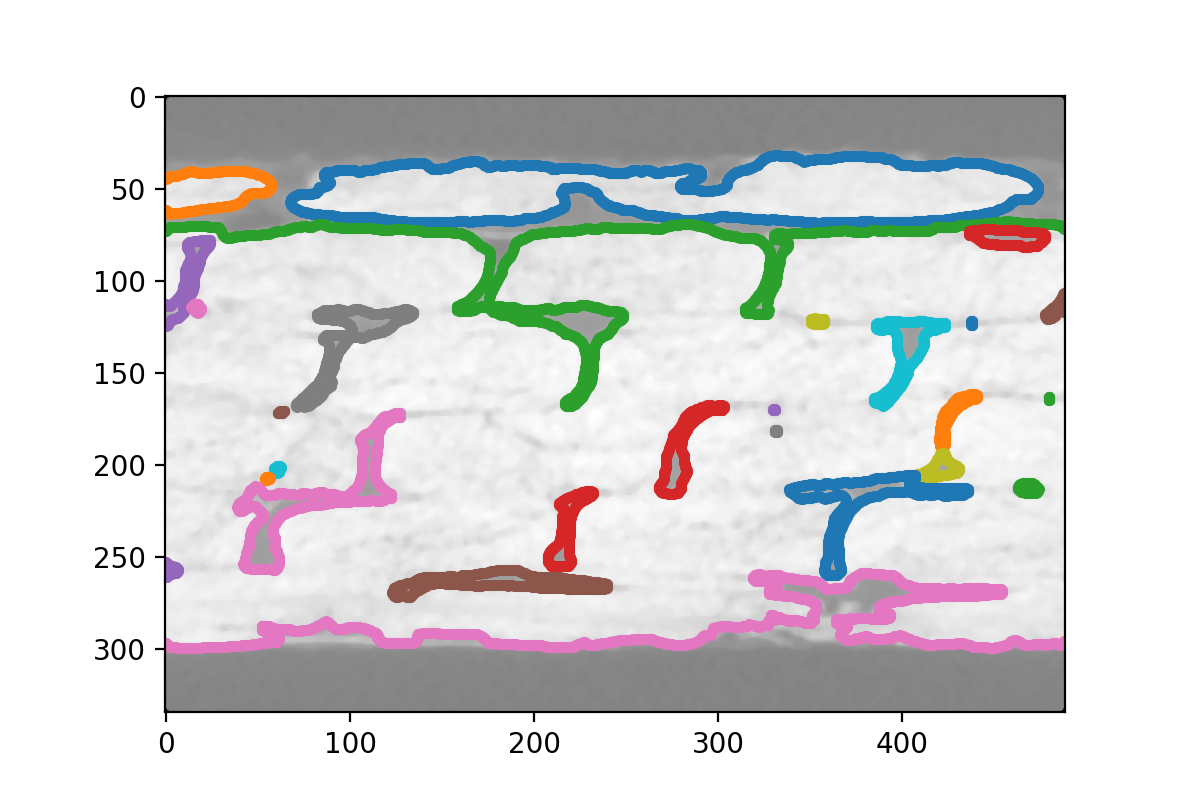

In [24]:
#%% DETECT CONTOURS
threshold = 45000 # desured threshold for contour detection
contours = skimage.measure.find_contours(image, threshold)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for c in contours:
    ax.plot(c[:,1], c[:,0],'.')
plt.show()

<IPython.core.display.Javascript object>


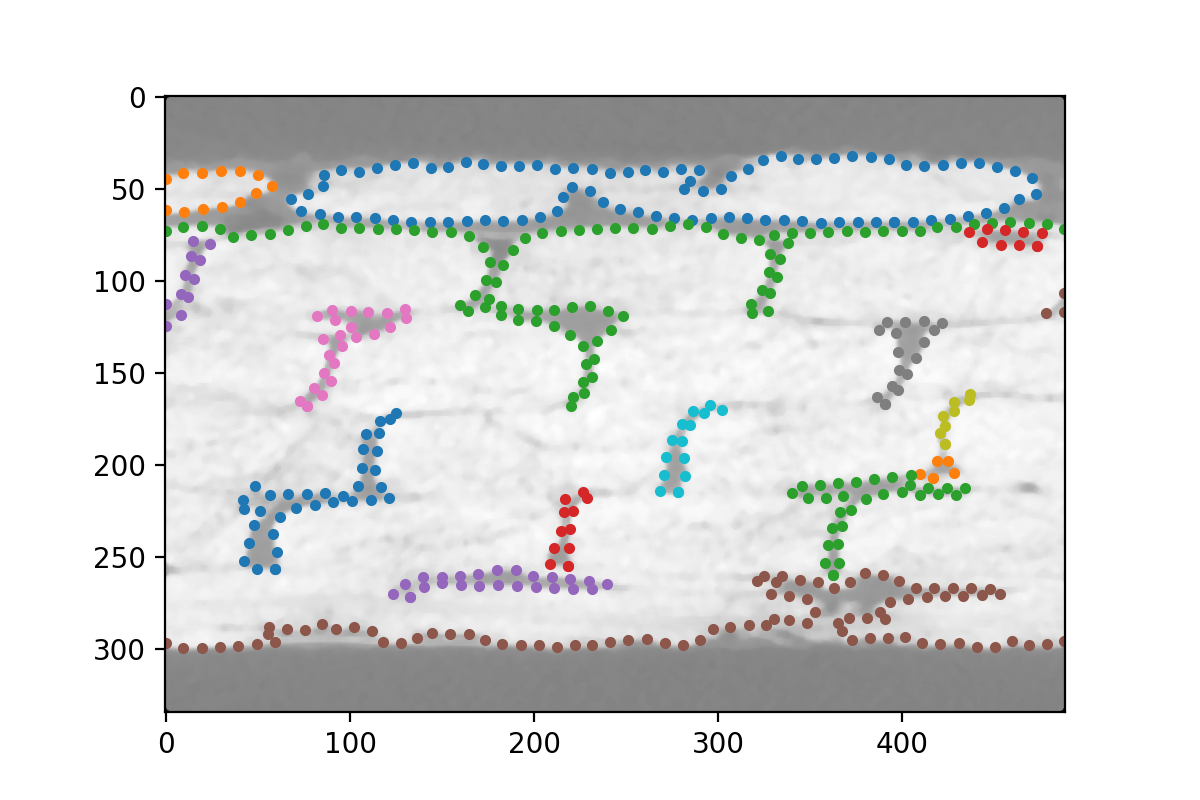

In [25]:
#%% RESAMPLE CONTOURS
average_edge_length = 10 # desired average edge length on the curves
contours = meshing.resample_contours(contours,average_edge_length)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for c in contours:
    ax.plot(c[:,1], c[:,0],'.')
plt.show()

<IPython.core.display.Javascript object>


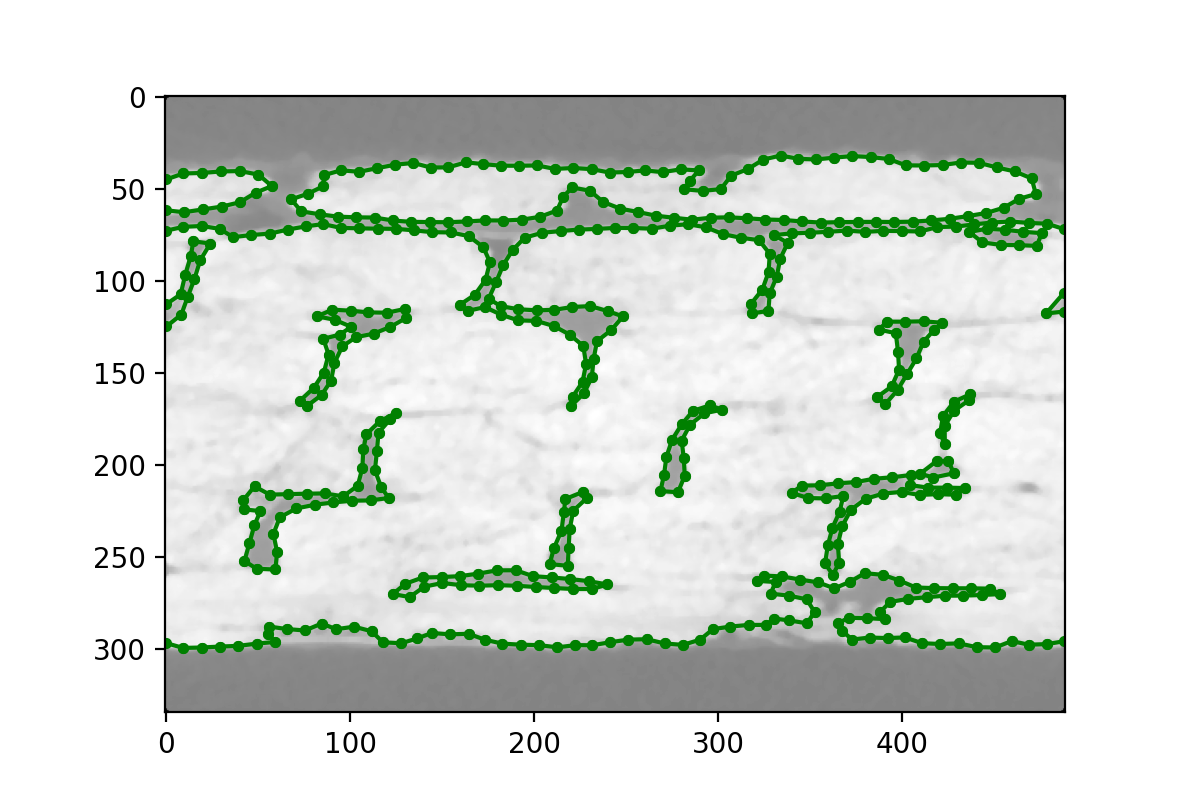

In [26]:
#%% COLLECT VERTICES AND EDGES OF CURVE SEGMENTS
vertices, edges = meshing.contours_to_segments(contours)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for e in edges:
    ax.plot(vertices[e,1], vertices[e,0], '.g')
    ax.plot(vertices[e,1], vertices[e,0], '-g')
plt.show()

<IPython.core.display.Javascript object>


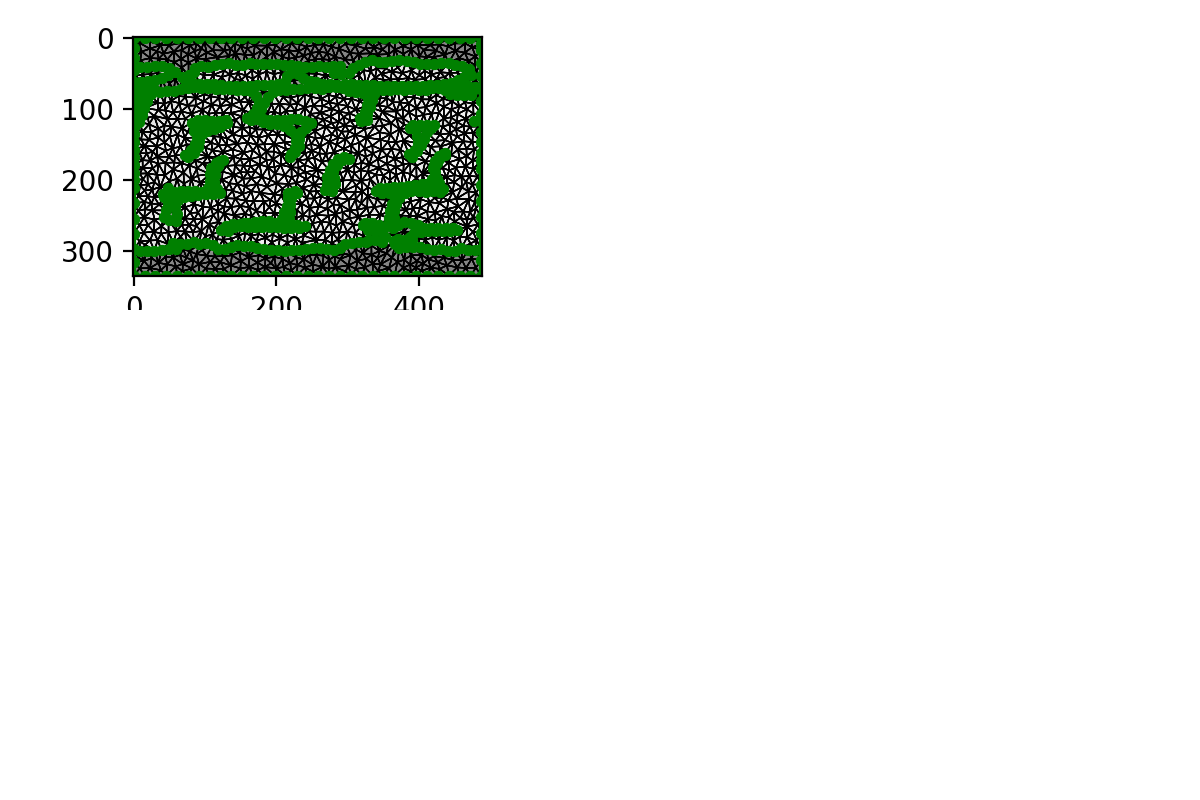

In [27]:
#%% TRIANGULATE IMAGE DOMAIN
max_area = (average_edge_length**2) # desired maximal triangle area
vertices, triangles, edges = meshing.triangulate_domain(vertices, edges, max_area, image.shape)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for t in triangles:
    tri = t[[0,1,2,0]]
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
for e in edges:
    ax.plot(vertices[e,1], vertices[e,0], '.g')
    ax.plot(vertices[e,1], vertices[e,0], '-g')
plt.show()

<IPython.core.display.Javascript object>


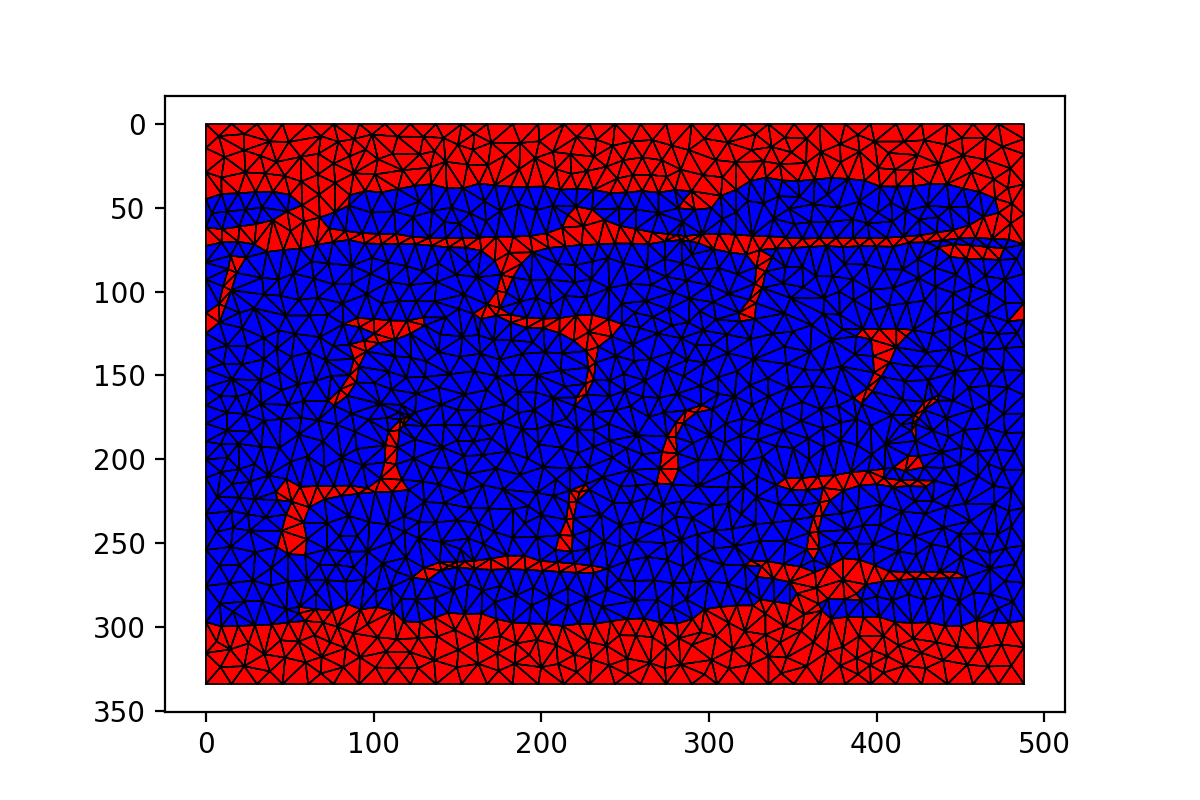

In [28]:
#%% COMPUTE TRIANGLE LABELS FROM CURVES - THE FASTER WAY OF DOING IT
labels = meshing.label_triangles_from_contours(vertices,triangles,edges)

fig, ax = plt.subplots(figsize=figsize)
for t, l in zip(triangles,labels):
    color = l.item(0)*'b'+(not l.item(0))*'r'
    ax.fill(vertices[t,1], vertices[t,0], color)
for t in triangles:
    tri = t[[0,1,2,0]]
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.show()

In [29]:
#%% COMPUTE TRIANGLE LABELS FROM IMAGE - THE SLOWER WAY OF DOING IT
#labels = meshing.label_triangles_from_intensity(vertices,triangles,image,threshold)
#
#fig, ax = plt.subplots(figsize=figsize)
#for t, l in zip(triangles,labels):
#    color = l.item(0)*'b'+(not l.item(0))*'r'
#    ax.fill(vertices[t,1], vertices[t,0], color)
#for t in triangles:
#    tri = t[[0,1,2,0]]
#    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
#    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
#ax.invert_yaxis()
#ax.set_aspect('equal')
#plt.show()

In [30]:
#%% SAVE MESH
filename = 'out/bundles_mesh.txt'
meshing.save_mesh(filename,vertices,triangles,labels)

In [31]:
#%% EXAMPLE OF LOADING THE MESH
vts, trs, lbs = meshing.load_mesh(filename)
    
#fig, ax = plt.subplots(figsize=figsize)
#for t, l in zip(trs,lbs):
#    color = l.item(0)*'b'+(not l.item(0))*'r'
#    ax.fill(vts[t,1], vts[t,0], color)
#for t in trs:
#    tri = t[[0,1,2,0]]
#    ax.plot(vts[tri,1], vts[tri,0], 'k', linewidth=0.5)
#    ax.plot(vts[tri,1], vts[tri,0], 'k', linewidth=0.5)
#ax.invert_yaxis()
#ax.set_aspect('equal')